# 라이브러리 및 데이터

In [1]:
import pandas as pd # 데이터 분석
import numpy as np # 행렬 연산
import random # 시드 제어
from pandas import Series, DataFrame
import sys
import time

import seaborn as sns
import matplotlib.pyplot as plt # 시각화
%matplotlib inline

import datetime
from workalendar.asia import SouthKorea # 한국의 공휴일

import lightgbm as lgb
import sklearn
from sklearn.model_selection import train_test_split

import re
import shap
import skimage

# 시드
import os
seed = 12345
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)

# Model

In [2]:
final_ans = pd.read_csv('data/final.csv', sep=',')
final_ans_test = pd.read_csv('data/final_test.csv', sep=',')

,date,avg_temp,min_temp,max_temp,rain_d,wind_d,wet_d,snow_d,year,month,...,holiday,power_d,power_d7,power_d6,power_d5,power_d4,power_d3,power_d2,power_d1,power
0,20170905,22.5,21.4,23.7,0.0,2.016667,63.500000,0.0,2017,9,...,0.0,0.133349,0.117071,0.116292,0.127583,0.124333,0.131833,0.138917,0.177417,0.181292
1,20170906,20.8,18.7,23.1,1.9,1.533333,82.458333,0.0,2017,9,...,0.0,0.142524,0.116292,0.127583,0.124333,0.131833,0.138917,0.177417,0.181292,0.170667
2,20170907,22.2,18.4,25.8,0.0,2.095833,80.083333,0.0,2017,9,...,0.0,0.150292,0.127583,0.124333,0.131833,0.138917,0.177417,0.181292,0.170667,0.166458
3,20170908,23.6,21.2,27.4,0.0,1.925000,77.833333,0.0,2017,9,...,0.0,0.155845,0.124333,0.131833,0.138917,0.177417,0.181292,0.170667,0.166458,0.146000
4,20170909,23.4,20.7,27.1,0.0,2.004167,80.958333,0.0,2017,9,...,0.0,0.158940,0.131833,0.138917,0.177417,0.181292,0.170667,0.166458,0.146000,0.267958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61451,20180625,24.7,20.3,29.0,0.0,1.933333,71.833333,0.0,2018,6,...,0.0,0.100674,0.103590,0.066542,0.063750,0.066167,0.101167,0.125125,0.178375,0.061333
61452,20180626,21.3,19.4,24.0,90.3,4.466667,90.166667,0.0,2018,6,...,0.0,0.094637,0.066542,0.063750,0.066167,0.101167,0.125125,0.178375,0.061333,0.066875
61453,20180627,20.5,18.5,23.0,0.2,2.583333,93.625000,0.0,2018,6,...,0.0,0.094685,0.063750,0.066167,0.101167,0.125125,0.178375,0.061333,0.066875,0.063583
61454,20180628,22.3,20.0,25.1,2.4,2.250000,93.583333,0.0,2018,6,...,0.0,0.094661,0.066167,0.101167,0.125125,0.178375,0.061333,0.066875,0.063583,0.064542


In [ ]:
for i in range(len(final_ans['date'])):
    final_ans['date'][i] = pd.Timestamp(final_ans['year'][i], final_ans['month'][i], final_ans['day'][i])
final_ans['date']

In [ ]:
for i in range(len(final['date'])):
    final_ans_test['date'][i] = pd.Timestamp(final_ans_test['year'][i], final_ans_test['month'][i], final_ans_test['day'][i])
final_ans_test['date']

In [4]:
final = pd.concat([final_ans, final_ans_test])

In [22]:
final = final.reset_index()
del final['index']
final

,date,avg_temp,min_temp,max_temp,rain_d,wind_d,wet_d,snow_d,year,month,...,holiday,power_d,power_d7,power_d6,power_d5,power_d4,power_d3,power_d2,power_d1,power
0,20170905,22.5,21.4,23.7,0.0,2.016667,63.500000,0.0,2017,9,...,0.0,0.133349,0.117071,0.116292,0.127583,0.124333,0.131833,0.138917,0.177417,0.181292
1,20170906,20.8,18.7,23.1,1.9,1.533333,82.458333,0.0,2017,9,...,0.0,0.142524,0.116292,0.127583,0.124333,0.131833,0.138917,0.177417,0.181292,0.170667
2,20170907,22.2,18.4,25.8,0.0,2.095833,80.083333,0.0,2017,9,...,0.0,0.150292,0.127583,0.124333,0.131833,0.138917,0.177417,0.181292,0.170667,0.166458
3,20170908,23.6,21.2,27.4,0.0,1.925000,77.833333,0.0,2017,9,...,0.0,0.155845,0.124333,0.131833,0.138917,0.177417,0.181292,0.170667,0.166458,0.146000
4,20170909,23.4,20.7,27.1,0.0,2.004167,80.958333,0.0,2017,9,...,0.0,0.158940,0.131833,0.138917,0.177417,0.181292,0.170667,0.166458,0.146000,0.267958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106862,20180625,24.7,20.3,29.0,0.0,1.933333,71.833333,0.0,2018,6,...,0.0,0.411842,0.533705,0.393125,0.342542,0.340542,0.341270,0.503208,0.428500,0.381667
106863,20180626,21.3,19.4,24.0,90.3,4.466667,90.166667,0.0,2018,6,...,0.0,0.390122,0.393125,0.342542,0.340542,0.341270,0.503208,0.428500,0.381667,0.370125
106864,20180627,20.5,18.5,23.0,0.2,2.583333,93.625000,0.0,2018,6,...,0.0,0.386836,0.342542,0.340542,0.341270,0.503208,0.428500,0.381667,0.370125,0.307042
106865,20180628,22.3,20.0,25.1,2.4,2.250000,93.583333,0.0,2018,6,...,0.0,0.381765,0.340542,0.341270,0.503208,0.428500,0.381667,0.370125,0.307042,0.365125


In [23]:
for i in range(len(final['date'])):
    final['date'][i] = pd.Timestamp(final['year'][i], final['month'][i], final['day'][i])
final['date'] = final['date'].dt.date
final


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0         2017-09-05 00:00:00
1         2017-09-06 00:00:00
2         2017-09-07 00:00:00
3         2017-09-08 00:00:00
4         2017-09-09 00:00:00
                 ...         
106862    2018-06-25 00:00:00
106863    2018-06-26 00:00:00
106864    2018-06-27 00:00:00
106865    2018-06-28 00:00:00
106866    2018-06-29 00:00:00
Name: date, Length: 106867, dtype: object

In [27]:
final = final.sort_values(by=['date'], axis=0)
final

,date,avg_temp,min_temp,max_temp,rain_d,wind_d,wet_d,snow_d,year,month,...,holiday,power_d,power_d7,power_d6,power_d5,power_d4,power_d3,power_d2,power_d1,power
36063,2016-08-11 00:00:00,29.0,26.1,33.6,0.0,2.033333,90.750000,0.0,2016,8,...,0.0,0.173224,0.012400,0.013125,0.013208,0.013250,1.134042,0.013042,0.013500,0.013000
36064,2016-08-12 00:00:00,29.0,26.5,32.4,0.0,2.345833,93.208333,0.0,2016,8,...,0.0,0.173310,0.013125,0.013208,0.013250,1.134042,0.013042,0.013500,0.013000,0.012917
36065,2016-08-13 00:00:00,28.9,26.7,31.8,0.0,2.183333,96.250000,0.0,2016,8,...,0.0,0.173280,0.013208,0.013250,1.134042,0.013042,0.013500,0.013000,0.012917,0.013083
36066,2016-08-14 00:00:00,28.4,26.8,30.3,0.0,2.320833,97.583333,0.0,2016,8,...,0.0,0.173262,0.013250,1.134042,0.013042,0.013500,0.013000,0.012917,0.013083,0.013125
36067,2016-08-15 00:00:00,28.0,25.9,31.5,0.0,2.154167,88.000000,0.0,2016,8,...,1.0,0.173244,1.134042,0.013042,0.013500,0.013000,0.012917,0.013083,0.013125,0.013042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65638,2018-06-29 00:00:00,22.3,20.0,26.0,0.4,1.879167,90.208333,0.0,2018,6,...,0.0,0.449490,0.381928,0.438583,0.588000,0.443792,0.454250,0.422292,0.417583,0.515734
37554,2018-06-29 00:00:00,22.3,20.0,26.0,0.4,1.879167,90.208333,0.0,2018,6,...,0.0,0.184611,0.229817,0.182500,0.230458,0.161125,0.180417,0.148750,0.159208,0.274545
106866,2018-06-29 00:00:00,22.3,20.0,26.0,0.4,1.879167,90.208333,0.0,2018,6,...,0.0,0.385277,0.341270,0.503208,0.428500,0.381667,0.370125,0.307042,0.365125,0.426954
22085,2018-06-30 00:00:00,24.0,19.5,28.5,0.0,1.395833,84.916667,0.0,2018,6,...,0.0,0.380819,0.376147,0.392458,0.359878,0.392458,0.359878,0.392458,0.392458,0.372433


In [44]:
for i in range(len(final['date'])):
    final['date'][i] = final['date'][i].strftime('%Y-%m-%d')
final['date']


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


36063     2016-08-11
36064     2016-08-12
36065     2016-08-13
36066     2016-08-14
36067     2016-08-15
             ...    
65638     2018-06-29
37554     2018-06-29
106866    2018-06-29
22085     2018-06-30
35468     2018-06-30
Name: date, Length: 106867, dtype: object

In [45]:
# date의 데이터 형식이 'yyyy-mm-dd'인 string이어서 lightgbm 내부에서 float으로 데이터를 변형시키지
# 못하여 데이터의 형식을 'yyyymmdd'로 변환
date_lst = []
for value in final['date'].values:
    val = re.sub(r"[-]","",value)
    date_lst.append(val)
final['date'] = date_lst
final

,date,avg_temp,min_temp,max_temp,rain_d,wind_d,wet_d,snow_d,year,month,...,holiday,power_d,power_d7,power_d6,power_d5,power_d4,power_d3,power_d2,power_d1,power
36063,20160811,29.0,26.1,33.6,0.0,2.033333,90.750000,0.0,2016,8,...,0.0,0.173224,0.012400,0.013125,0.013208,0.013250,1.134042,0.013042,0.013500,0.013000
36064,20160812,29.0,26.5,32.4,0.0,2.345833,93.208333,0.0,2016,8,...,0.0,0.173310,0.013125,0.013208,0.013250,1.134042,0.013042,0.013500,0.013000,0.012917
36065,20160813,28.9,26.7,31.8,0.0,2.183333,96.250000,0.0,2016,8,...,0.0,0.173280,0.013208,0.013250,1.134042,0.013042,0.013500,0.013000,0.012917,0.013083
36066,20160814,28.4,26.8,30.3,0.0,2.320833,97.583333,0.0,2016,8,...,0.0,0.173262,0.013250,1.134042,0.013042,0.013500,0.013000,0.012917,0.013083,0.013125
36067,20160815,28.0,25.9,31.5,0.0,2.154167,88.000000,0.0,2016,8,...,1.0,0.173244,1.134042,0.013042,0.013500,0.013000,0.012917,0.013083,0.013125,0.013042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65638,20180629,22.3,20.0,26.0,0.4,1.879167,90.208333,0.0,2018,6,...,0.0,0.449490,0.381928,0.438583,0.588000,0.443792,0.454250,0.422292,0.417583,0.515734
37554,20180629,22.3,20.0,26.0,0.4,1.879167,90.208333,0.0,2018,6,...,0.0,0.184611,0.229817,0.182500,0.230458,0.161125,0.180417,0.148750,0.159208,0.274545
106866,20180629,22.3,20.0,26.0,0.4,1.879167,90.208333,0.0,2018,6,...,0.0,0.385277,0.341270,0.503208,0.428500,0.381667,0.370125,0.307042,0.365125,0.426954
22085,20180630,24.0,19.5,28.5,0.0,1.395833,84.916667,0.0,2018,6,...,0.0,0.380819,0.376147,0.392458,0.359878,0.392458,0.359878,0.392458,0.392458,0.372433


In [46]:
X = final[final_ans.columns.difference(['power'])]
Y = final['power']

In [47]:
X['date'] = X['date'].astype(float)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [60]:
x_train, x_valtest, y_train, y_valtest = train_test_split(X, Y, test_size = 0.2, shuffle=False, random_state=seed)
x_val, x_test, y_val, y_test = train_test_split(x_valtest, y_valtest, test_size = 0.5, shuffle=False, random_state=seed)

In [61]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

(85493, 23) (85493,) (10687, 23) (10687,) (10687, 23) (10687,)


In [62]:
print(x_train.dtypes)
print(x_val.dtypes)
print(x_test.dtypes)

avg_temp     float64
date         float64
day            int64
dayofweek      int64
holiday      float64
max_temp     float64
min_temp     float64
month          int64
power_d      float64
power_d1     float64
power_d2     float64
power_d3     float64
power_d4     float64
power_d5     float64
power_d6     float64
power_d7     float64
rain_d       float64
snow_d       float64
week           int64
weekend        int64
wet_d        float64
wind_d       float64
year           int64
dtype: object
avg_temp     float64
date         float64
day            int64
dayofweek      int64
holiday      float64
max_temp     float64
min_temp     float64
month          int64
power_d      float64
power_d1     float64
power_d2     float64
power_d3     float64
power_d4     float64
power_d5     float64
power_d6     float64
power_d7     float64
rain_d       float64
snow_d       float64
week           int64
weekend        int64
wet_d        float64
wind_d       float64
year           int64
dtype: object
avg_te

In [63]:
train_lgb = lgb.Dataset(x_train, label = y_train)
val_lgb = lgb.Dataset(x_val, label = y_val)
params = {'random_seed':seed, 'bagging_seed':seed,
          'feature_fraction_seed':seed, 'data_random_seed':seed,
          'drop_seed':seed,
          
          'boosting_type':'gbdt', 'objective':'huber',
          'learning_rate':0.001, 'num_leaves':63, 'max_depth':-1,
          'bagging_fraction':0.1, 'feature_fraction':0.8,
          'lambda_l1':10.0, 'lambda_l2':30.0, 'max_bin':255}
model = lgb.train(params, train_lgb, valid_sets = val_lgb,
                  num_boost_round = 2000, early_stopping_rounds = 100,
                  verbose_eval = 200)

Training until validation scores don't improve for 100 rounds
[200]	valid_0's huber: 0.00482956
[400]	valid_0's huber: 0.00384813
[600]	valid_0's huber: 0.00317948
[800]	valid_0's huber: 0.00272416
[1000]	valid_0's huber: 0.0024137
[1200]	valid_0's huber: 0.00220354
[1400]	valid_0's huber: 0.00205533
[1600]	valid_0's huber: 0.00195109
[1800]	valid_0's huber: 0.00188056
[2000]	valid_0's huber: 0.00183094
Did not meet early stopping. Best iteration is:
[2000]	valid_0's huber: 0.00183094


In [64]:
lgb_test, lgb_valid = model.predict(x_test), model.predict(x_val)

In [65]:
lgb_test

array([0.30430484, 0.29238167, 0.30626493, ..., 0.35681906, 0.37214929,
       0.31386082])

In [66]:
y_test.values

array([0.28725   , 0.29783333, 0.29245833, ..., 0.42695442, 0.37243258,
       0.37259527])

In [67]:
t = np.arange(0,len(lgb_test),1)
t2 = np.arange(0,len(lgb_test),1)

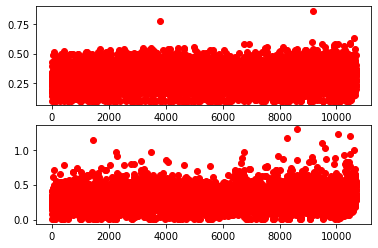

In [68]:
plt.subplot(211)
plt.plot(t, lgb_test, 'or')

plt.subplot(212)
plt.plot(t2, y_test.values, 'or')

plt.show()

In [69]:
def smape(array_1, array_2):
    score = 100*np.mean(2*abs(array_1 - array_2)/(abs(array_1)+abs(array_2)))
    return score

In [70]:
# predict과 test set의 smape 계산
lgb_test_smape, lgb_valid_smape = smape(lgb_test, y_test), smape(lgb_valid, y_val)

In [71]:
print(lgb_test_smape)
print(lgb_valid_smape)

17.43340518099688
17.166494902618375


In [72]:
np.savetxt('data/lgb_test.csv', lgb_test, delimiter=',')
np.savetxt('data/y_test.csv', y_test, delimiter=',')

In [15]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


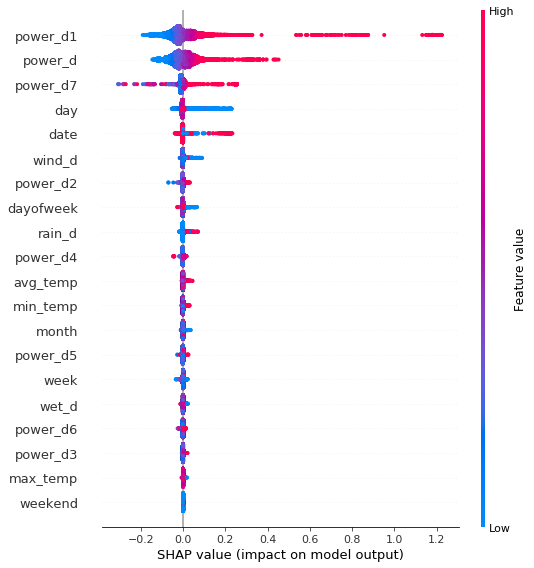

In [19]:
shap.summary_plot(shap_values, x_test)

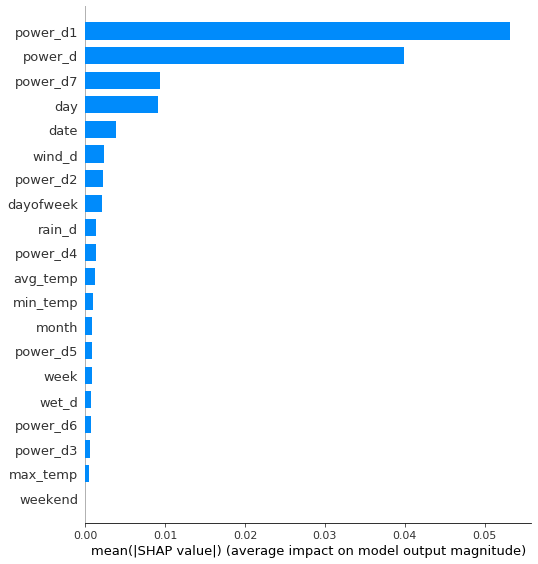

In [20]:
shap.summary_plot(shap_values, x_test, plot_type="bar")

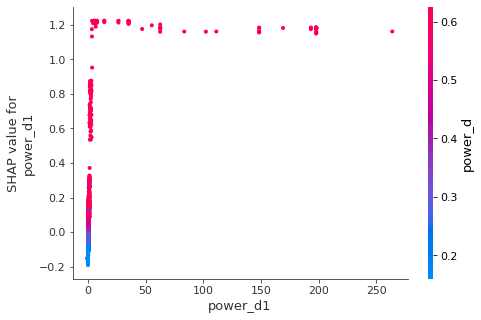

In [21]:
shap.dependence_plot('power_d1', shap_values, x_test)

In [22]:
lgb_test

array([0.63317928, 0.47291244, 0.52996015, ..., 0.37292038, 0.46459811,
       0.37080451])

In [23]:
y_test

122835    0.684945
36252     0.566315
74162     0.494792
139834    0.637583
136711    0.326000
            ...   
95386     0.459333
76198     0.531292
192661    0.312083
167464    0.420205
75561     0.346333
Name: power, Length: 19510, dtype: float64

In [24]:
np.savetxt('data/lgb_test.csv', lgb_test, delimiter=',')
np.savetxt('data/y_test.csv', y_test, delimiter=',')